In [288]:
require(caret)
require(tidyverse)
require(glmnet)
require(skimr)
require(pROC)
library(readr)

# Read Data

In [144]:
hotel_df <- readRDS("Data/hotel.rds")
head(hotel_df)

Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,⋯,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_dt,day_of_week,day_type,total_people,season
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<date>,<fct>,<fct>,<dbl>,<fct>
INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,⋯,0,0,65.00,0,Not_Canceled,2017-10-02,Monday,Weekday,2,autumm
INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,⋯,0,0,106.68,1,Not_Canceled,2018-11-06,Tuesday,Weekday,2,autumm
INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,⋯,0,0,100.00,0,Canceled,2018-05-20,Sunday,Weekend,2,spring
INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,⋯,0,0,94.50,0,Canceled,2018-04-11,Wednesday,Weekday,2,spring
INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,⋯,0,0,115.00,1,Canceled,2018-09-13,Thursday,Weekday,2,autumm
INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,⋯,0,0,107.55,1,Not_Canceled,2017-10-15,Sunday,Weekend,2,autumm


## Check Structure

In [149]:
str(hotel_df)

tibble [33,418 × 24] (S3: tbl_df/tbl/data.frame)
 $ Booking_ID                          : Factor w/ 33418 levels "INN00001","INN00002",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ no_of_adults                        : num [1:33418] 2 2 2 2 2 2 2 3 2 1 ...
 $ no_of_children                      : num [1:33418] 0 0 0 0 0 0 0 0 0 0 ...
 $ no_of_weekend_nights                : num [1:33418] 1 2 0 1 0 1 1 0 0 1 ...
 $ no_of_week_nights                   : num [1:33418] 2 3 2 1 2 3 3 4 5 0 ...
 $ type_of_meal_plan                   : Factor w/ 4 levels "Meal Plan 1",..: 1 4 1 4 2 1 1 1 1 4 ...
 $ required_car_parking_space          : num [1:33418] 0 0 0 0 0 0 0 0 0 0 ...
 $ room_type_reserved                  : Factor w/ 7 levels "Room_Type 1",..: 1 1 1 1 1 1 4 1 4 1 ...
 $ lead_time                           : num [1:33418] 224 5 211 48 346 34 83 121 44 0 ...
 $ arrival_year                        : num [1:33418] 2017 2018 2018 2018 2018 ...
 $ arrival_month                       : num [1:33418] 10 11 5

In [151]:
clean_hotel_df <- hotel_df %>%
  select(-Booking_ID, -arrival_year, -arrival_month,
         -arrival_date,-arrival_dt, -day_type, 
         -day_of_week, -total_people)

str(clean_hotel_df)

tibble [33,418 × 16] (S3: tbl_df/tbl/data.frame)
 $ no_of_adults                        : num [1:33418] 2 2 2 2 2 2 2 3 2 1 ...
 $ no_of_children                      : num [1:33418] 0 0 0 0 0 0 0 0 0 0 ...
 $ no_of_weekend_nights                : num [1:33418] 1 2 0 1 0 1 1 0 0 1 ...
 $ no_of_week_nights                   : num [1:33418] 2 3 2 1 2 3 3 4 5 0 ...
 $ type_of_meal_plan                   : Factor w/ 4 levels "Meal Plan 1",..: 1 4 1 4 2 1 1 1 1 4 ...
 $ required_car_parking_space          : num [1:33418] 0 0 0 0 0 0 0 0 0 0 ...
 $ room_type_reserved                  : Factor w/ 7 levels "Room_Type 1",..: 1 1 1 1 1 1 4 1 4 1 ...
 $ lead_time                           : num [1:33418] 224 5 211 48 346 34 83 121 44 0 ...
 $ market_segment_type                 : Factor w/ 5 levels "Aviation","Complementary",..: 4 5 5 5 5 5 5 4 5 5 ...
 $ repeated_guest                      : num [1:33418] 0 0 0 0 0 0 0 0 0 0 ...
 $ no_of_previous_cancellations        : num [1:33418] 0 0 0 0 0 0 

## Test-Train Split

In [152]:
factor_cols <- c("type_of_meal_plan",
         "room_type_reserved",
         "market_segment_type",
         "repeated_guest",
         "required_car_parking_space",
         "season")

quant_cols <- c("no_of_adults",
         "no_of_children",
         "no_of_weekend_nights",
         "no_of_week_nights",
         "no_of_previous_cancellations",
         "no_of_previous_bookings_not_canceled",
         "no_of_special_requests",
         "lead_time",
         "avg_price_per_room")

Split the data into 80% training and 20% testing.

## Center and Scale Data

In [155]:
# Format labels and select features
Y = make.names(hotel_df$booking_status)
Y = relevel(as.factor(Y), ref="Not_Canceled")
X = hotel_df %>%
  select(any_of(c(factor_cols, quant_cols)))

In [157]:
# Format labels and select features
Y = make.names(hotel_df$booking_status)
Y = relevel(as.factor(Y), ref="Not_Canceled")
X = hotel_df %>%
  select(any_of(c(factor_cols, quant_cols)))

# Create train-test split
set.seed(1)
trainSplit = createDataPartition(y = Y, p = 0.8, list = FALSE)

Ytrain = Y[trainSplit]
Xtrain = X[trainSplit,]
Ytest  = Y[-trainSplit]
Xtest  = X[-trainSplit,]

# Process train data
train_factor <- Xtrain %>%
  select(any_of(factor_cols)) %>%
  mutate_all(factor)

train_quant <- Xtrain %>%
  select(any_of(quant_cols))

# Center and scale continuous variables
pre_process_function <- preProcess(train_quant, method=c("center","scale"))
processed_train_quant <- predict(pre_process_function, train_quant)
processed_Xtrain <- cbind(train_factor, processed_train_quant)

# Process test data
test_factor <- Xtest %>%
  select(any_of(factor_cols)) %>%
  mutate_all(factor)

test_quant <- Xtest %>%
  select(any_of(quant_cols))

# Center and scale continuous variables
processed_test_quant <- predict(pre_process_function, test_quant)
processed_Xtest <- cbind(test_factor, processed_test_quant)

# Convert features into matrices for glmnet
Xtrain_mat = model.matrix( ~ .-1, processed_Xtrain)
Xtest_mat = model.matrix( ~ .-1, processed_Xtest)

In [158]:
head(Xtrain_mat)

,type_of_meal_planMeal Plan 1,type_of_meal_planMeal Plan 2,type_of_meal_planMeal Plan 3,type_of_meal_planNot Selected,room_type_reservedRoom_Type 2,room_type_reservedRoom_Type 3,room_type_reservedRoom_Type 4,room_type_reservedRoom_Type 5,room_type_reservedRoom_Type 6,room_type_reservedRoom_Type 7,⋯,seasonwinter,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,lead_time,avg_price_per_room
1,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,1.57968987,-1.12910890
2,0,0,0,1,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,1.3737933,0.5560364,-0.06378754,-0.08322939,0.4727701,-0.95897292,0.06473920
3,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,-0.9320336,-0.1517161,-0.06378754,-0.08322939,-0.7919396,1.42899299,-0.12659730
4,0,0,0,1,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.8594686,-0.06378754,-0.08322939,-0.7919396,-0.46051401,-0.28413484
5,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,0.5560364,-0.06378754,-0.08322939,0.4727701,-0.62280296,0.08965877
6,1,0,0,0,0,0,1,0,0,0,⋯,1,0.2926958,-0.2591334,0.2208799,0.5560364,-0.06378754,-0.08322939,0.4727701,-0.05479165,0.03409099


# Fit Model

## Elastic-Net

### Run Elastic-Net Cross-Validation

In [159]:
library(doParallel)
cl <- makePSOCKcluster(14)
registerDoParallel(cl)

ptime <- system.time({set.seed(1)
K            = 10
trainControl = trainControl(method = "repeartcv", repeats = 2, number = K, savePredictions=TRUE,
                            classProbs=TRUE)#, summaryFunction=mnLogLoss)
tuneGrid     = expand.grid('alpha'=c(0, 0.25, .5, 0.75, 1),'lambda' = c(seq(1,10,2) %o% 10^(-4:1)))

elasticOut   = train(x = Xtrain_mat, y = Ytrain,
                     method = "glmnet", metric="logLoss",
                     trControl = trainControl, tuneGrid = tuneGrid)#### Answer 1.1

elasticOut$bestTune}
)
stopCluster(cl)

Warning message in train.default(x = Xtrain_mat, y = Ytrain, method = "glmnet", :
“The metric "logLoss" was not in the result set. Accuracy will be used instead.”


In [160]:
ptime

   user  system elapsed 
  4.736   1.318  16.020 

In [260]:
elasticOut$bestTune

,alpha,lambda
,<dbl>,<dbl>
32,0.25,3e-04


In [261]:
elasticOut$results[31:33,]

,alpha,lambda,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31,0.25,1e-04,0.8042635,0.5452519,0.006577331,0.01499163
32,0.25,3e-04,0.8043009,0.5453255,0.006579337,0.01500012
33,0.25,5e-04,0.8041139,0.5446401,0.006584821,0.01502381


In [262]:
# Test thresholds
thresholder(elasticOut, c(0.25,0.4,0.5,0.6,0.75,0.8,0.9))

alpha,lambda,prob_threshold,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy,Accuracy,Kappa,J,Dist
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.25,3e-04,0.25,0.9675861,0.3690883,0.7544296,0.8503996,0.7544296,0.9675861,0.8478067,0.6669908,0.6453708,0.8554705,0.6683372,0.7682804,0.3921955,0.3366744,0.6317609
0.25,3e-04,0.40,0.9312466,0.5298211,0.7986926,0.7937657,0.7986926,0.9312466,0.8598821,0.6669908,0.6211331,0.7777073,0.7305338,0.7975680,0.5029036,0.4610676,0.4752218
0.25,3e-04,0.50,0.8843092,0.6440535,0.8326810,0.7355588,0.8326810,0.8843092,0.8577032,0.6669908,0.5898258,0.7083599,0.7641814,0.8043009,0.5453255,0.5283627,0.3743512
0.25,3e-04,0.60,0.8278382,0.7307663,0.8603407,0.6796188,0.8603407,0.8278382,0.8437373,0.6669908,0.5521599,0.6418179,0.7793022,0.7955110,0.5482519,0.5586045,0.3198012
0.25,3e-04,0.75,0.7099040,0.8455576,0.9020436,0.5928197,0.9020436,0.7099040,0.7944791,0.6669908,0.4734997,0.5249307,0.7777308,0.7550779,0.5018988,0.5554616,0.3288005
0.25,3e-04,0.80,0.6490025,0.8944170,0.9249271,0.5600214,0.9249271,0.6490025,0.7627037,0.6669908,0.4328792,0.4680394,0.7717097,0.7307282,0.4727610,0.5434195,0.3666886
0.25,3e-04,0.90,0.4362945,0.9702342,0.9671305,0.4621958,0.9671305,0.4362945,0.6012605,0.6669908,0.2910050,0.3009173,0.7032644,0.6141019,0.3188070,0.4065287,0.5645231


In [668]:
saveRDS(elasticOut, "models/elasticnet_cv.rds")

### Refit Elastic-Net

In [669]:
glmnetOut <- glmnet(x=Xtrain_mat, y=Ytrain, 
                    alpha=elasticOut$bestTune$alpha, 
                    lambda=elasticOut$bestTune$lambda,
                    family="binomial", standardize=FALSE)
saveRDS(glmnetOut, "models/final_glmnet.rds")

In [670]:
coef(glmnetOut, s=elasticOut$bestTune$lambda)

29 x 1 sparse Matrix of class "dgCMatrix"
                                              s1
(Intercept)                          -0.77890471
type_of_meal_planMeal Plan 1         -0.12599530
type_of_meal_planMeal Plan 2          .         
type_of_meal_planMeal Plan 3          .         
type_of_meal_planNot Selected         0.14673776
room_type_reservedRoom_Type 2        -0.23496382
room_type_reservedRoom_Type 3         .         
room_type_reservedRoom_Type 4        -0.15126791
room_type_reservedRoom_Type 5        -0.61346262
room_type_reservedRoom_Type 6        -0.77441205
room_type_reservedRoom_Type 7        -0.67730261
market_segment_typeComplementary     -0.47456691
market_segment_typeCorporate         -0.07337905
market_segment_typeOffline           -1.28529121
market_segment_typeOnline             0.56356236
repeated_guest1                      -1.05112326
required_car_parking_space1          -1.29009347
seasonspring                          0.09641026
seasonsummer               

In [373]:
probHatTrain <- predict(glmnetOut, Xtrain_mat, s=elasticOut$bestTune$lambda, type="response")
YhatTrainGlmnet <- ifelse(probHatTrain >0.5, "Canceled", "Not_Canceled")
mean(YhatTrainGlmnet[,"s1"] == Ytrain)

[1] 0.8028053

## XGBoost

In [287]:
require(xgboost)

### XGBoost Cross-Validation

In [253]:
library(doParallel)
cl <- makePSOCKcluster(14)
registerDoParallel(cl)

ptime <- system.time({
    set.seed(1)
    
    K<-10
    trControl = trainControl(method = "cv", number = K, classProbs=TRUE, savePredictions = TRUE)

    tuneGrid = expand.grid('nrounds'=1000,'max_depth' = 3,
                      'eta' = 0.05, 'gamma' = 0,'colsample_bytree' = 1,
                      'min_child_weight' = 0,'subsample' = 0.5
                      )

    boostOut = train(x = Xtrain_mat, y = Ytrain,
    method = "xgbTree",
    tuneGrid = tuneGrid,
    trControl = trControl)
})

stopCluster(cl)

In [278]:
ptime

    user   system  elapsed 
 130.879    0.210 1799.081 

In [275]:
boostTrainPreds <- predict(boostOut, Xtrain_mat,type="raw")
mean(boostTrainPreds == Ytrain)

[1] 0.8825136

In [257]:
boostOut$results

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000,3,0.05,0,1,0,0.5,0.8736106,0.7087323,0.007458487,0.0176732


In [258]:
# Test thresholds
thresholder(boostOut, c(0.25,0.4,0.5,0.6,0.75,0.8,0.9))

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample,prob_threshold,Sensitivity,Specificity,⋯,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy,Accuracy,Kappa,J,Dist
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,3,0.05,0,1,0,0.5,0.25,0.9829518,0.5489151,⋯,0.9829518,0.8903041,0.6669908,0.6556198,0.8058353,0.7659334,0.8384135,0.5937540,0.5318669,0.4514262
1000,3,0.05,0,1,0,0.5,0.40,0.9523324,0.7081842,⋯,0.9523324,0.9078358,0.6669908,0.6351972,0.7323738,0.8302583,0.8710297,0.6946557,0.6605167,0.2957562
1000,3,0.05,0,1,0,0.5,0.50,0.9282746,0.7641201,⋯,0.9282746,0.9073920,0.6669908,0.6191509,0.6977004,0.8461973,0.8736106,0.7087323,0.6923947,0.2465992
1000,3,0.05,0,1,0,0.5,0.60,0.9001791,0.8046688,⋯,0.9001791,0.9012111,0.6669908,0.6004117,0.6654582,0.8524239,0.8683743,0.7040351,0.7048479,0.2195429
1000,3,0.05,0,1,0,0.5,0.75,0.8046208,0.8848680,⋯,0.8046208,0.8641618,0.6669908,0.5366756,0.5750153,0.8447444,0.8313450,0.6449567,0.6894889,0.2271462
1000,3,0.05,0,1,0,0.5,0.80,0.7388969,0.9185634,⋯,0.7388969,0.8303802,0.6669908,0.4928383,0.5199568,0.8287302,0.7987289,0.5920649,0.6574604,0.2737868
1000,3,0.05,0,1,0,0.5,0.90,0.5696510,0.9769746,⋯,0.5696510,0.7204860,0.6669908,0.3799524,0.3876203,0.7733128,0.7052937,0.4517925,0.5466256,0.4309894


In [286]:
xgb.importance(model = boostOut$finalModel)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
lead_time,0.4069066159,2.806174e-01,0.28074385
avg_price_per_room,0.1752997146,3.150348e-01,0.29154169
no_of_special_requests,0.1427421459,9.530555e-02,0.07708458
market_segment_typeOnline,0.0859886356,1.824505e-02,0.02519496
seasonwinter,0.0422833700,2.973122e-02,0.03134373
market_segment_typeOffline,0.0287692237,3.257377e-02,0.02984403
no_of_week_nights,0.0266062242,5.817366e-02,0.06283743
no_of_adults,0.0233651971,2.187367e-02,0.02939412
no_of_weekend_nights,0.0175613051,1.916880e-02,0.03554289


In [279]:
saveRDS(boostOut, "models/xgboost.rds")

# Compare Models
Use this to compare the performance between the models: [link](https://cran.r-project.org/web/packages/caret/vignettes/caret.html)

In [682]:
elasticOut <- readRDS("models/elasticnet_cv.rds")
glmnetOut <- readRDS("models/final_glmnet.rds")
boostOut <- readRDS("models/xgboost.rds")

## ROC

### Logistic Regression

Setting levels: control = Not_Canceled, case = Canceled

Setting direction: controls < cases



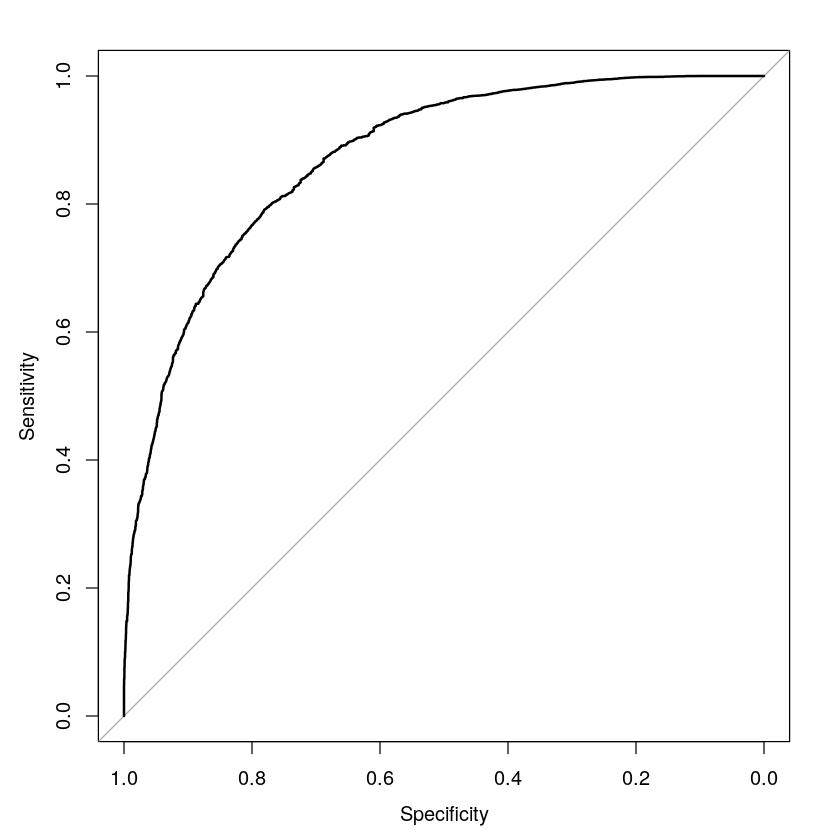

In [357]:
elasticROC <- roc(response=Ytrain, predict(elasticOut, Xtrain_mat, s=elasticOut$bestTune$lambda, type="prob")$Canceled)
plot(elasticROC)

In [358]:
auc(elasticROC)

Area under the curve: 0.8724

### XGBoost

Setting levels: control = Not_Canceled, case = Canceled

Setting direction: controls < cases



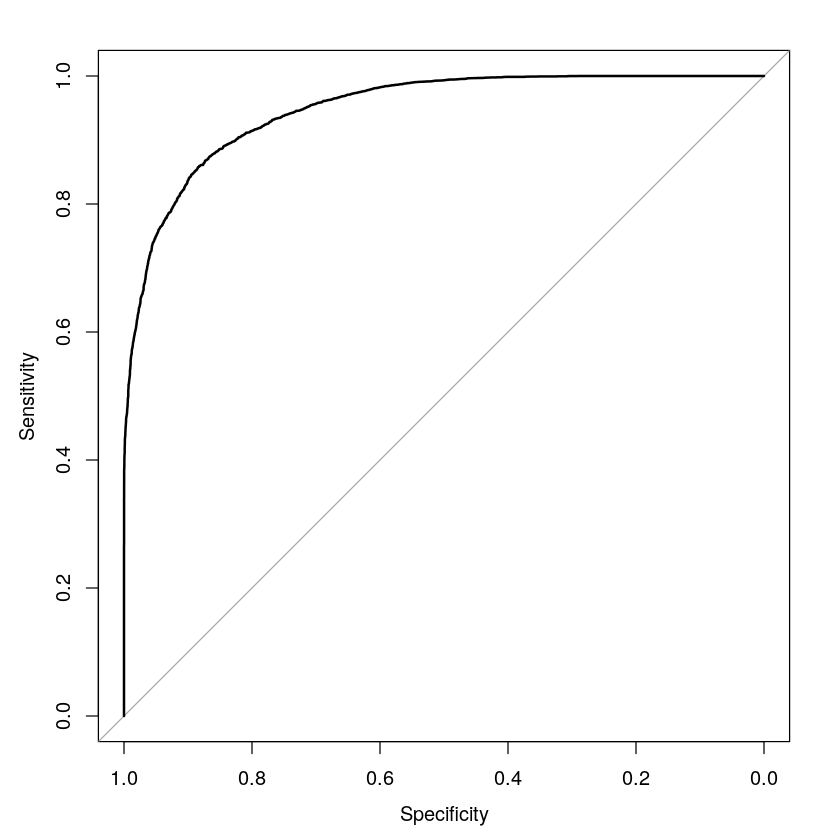

In [350]:
boostROC <- roc(response=Ytrain, predict(boostOut,Xtrain_mat,type="prob")$Canceled)
plot(boostROC)

In [351]:
auc(boostROC)

Area under the curve: 0.9484

## t-test of Models

In [281]:
resamps <- resamples(list(elastic = elasticOut, boost = boostOut))
summary(resamps)


Call:
summary.resamples(object = resamps)

Models: elastic, boost 
Number of resamples: 10 

Accuracy 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
elastic 0.7938646 0.8007856 0.8038153 0.8043009 0.8058544 0.8189978    0
boost   0.8645716 0.8699027 0.8711186 0.8736106 0.8735041 0.8904263    0

Kappa 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
elastic 0.5204163 0.5395117 0.5446605 0.5453255 0.5483626 0.5801468    0
boost   0.6868320 0.6995925 0.7027873 0.7087323 0.7103085 0.7476622    0


In [282]:
diffs <- diff(resamps)
summary(diffs)


Call:
summary.diff.resamples(object = diffs)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Accuracy 
        elastic   boost   
elastic           -0.06931
boost   1.333e-12         

Kappa 
        elastic   boost  
elastic           -0.1634
boost   3.388e-12        


# Plot Features

### Lead Time by Model

In [602]:
# Create vector of lead times, standardize, then create tibble
lead_time<-seq(min(Xtrain$lead_time), max(Xtrain$lead_time))
standardized_lead_time <- (lead_time - pre_process_function$mean[["lead_time"]])/pre_process_function$std[["lead_time"]]
lead_time_grid <- tibble(lead_time=standardized_lead_time)
lead_time_len <- length(lead_time)

# Select dummy variable columns
mat_factor_cols <- colnames(Xtrain_mat)[!(colnames(Xtrain_mat) %in% quant_cols)]

# Get most common value for dummy variables
for (x in mat_factor_cols){
    value_counts <- Xtrain_mat[,x] %>%
        table()
    lead_time_grid <- lead_time_grid %>%
        mutate(!!x := rep(as.numeric(names(which.max(value_counts))), len))
}

# Get median quantitative values
for (x in quant_cols[quant_cols!="lead_time"]){
    col_median <- Xtrain_mat[,x] %>%
        median()

    lead_time_grid <- lead_time_grid %>%
        mutate(!!x := rep(col_median, len))
}

# Create matrix and format names correctly
lead_time_grid <- model.matrix(~.-1,lead_time_grid)
colnames(lead_time_grid) <- sapply(colnames(lead_time_grid),str_replace_all,pattern="`",replacement="", USE.NAMES=FALSE)
lead_time_grid <- lead_time_grid[,colnames(Xtrain_mat)]

head(lead_time_grid)

,type_of_meal_planMeal Plan 1,type_of_meal_planMeal Plan 2,type_of_meal_planMeal Plan 3,type_of_meal_planNot Selected,room_type_reservedRoom_Type 2,room_type_reservedRoom_Type 3,room_type_reservedRoom_Type 4,room_type_reservedRoom_Type 5,room_type_reservedRoom_Type 6,room_type_reservedRoom_Type 7,⋯,seasonwinter,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,lead_time,avg_price_per_room
1,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,-1.0169333,-0.1265973
2,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,-1.0053412,-0.1265973
3,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,-0.9937491,-0.1265973
4,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,-0.9821571,-0.1265973
5,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,-0.9705650,-0.1265973
6,1,0,0,0,0,0,0,0,0,0,⋯,0,0.2926958,-0.2591334,0.2208799,-0.1517161,-0.06378754,-0.08322939,-0.7919396,-0.9589729,-0.1265973


In [659]:
# Make predictions and pivot
lead_time_preds = lead_time_grid %>%
    as_tibble() %>%
    select(lead_time) %>%
    mutate(
        # XGBoost pred and format
        XGBoost = predict(boostOut, lead_time_grid,type="prob")%>%pull("Canceled"),
        # GLMNet pred and format
        GLMNet = as.vector(
            predict(glmnetOut, lead_time_grid,s=elasticOut$bestTune$lambda, type="response")[,"s1"]
        ),
        # Un-standardize lead time
        lead_time = lead_time*pre_process_function$std[["lead_time"]]+pre_process_function$mean[["lead_time"]]
    ) %>%
    pivot_longer(!lead_time, names_to="model", values_to="probability")
head(lead_time_preds)

lead_time,model,probability
<dbl>,<chr>,<dbl>
0,XGBoost,0.08332986
0,GLMNet,0.29360043
1,XGBoost,0.08596462
1,GLMNet,0.29695507
2,XGBoost,0.16863900
2,GLMNet,0.30033175


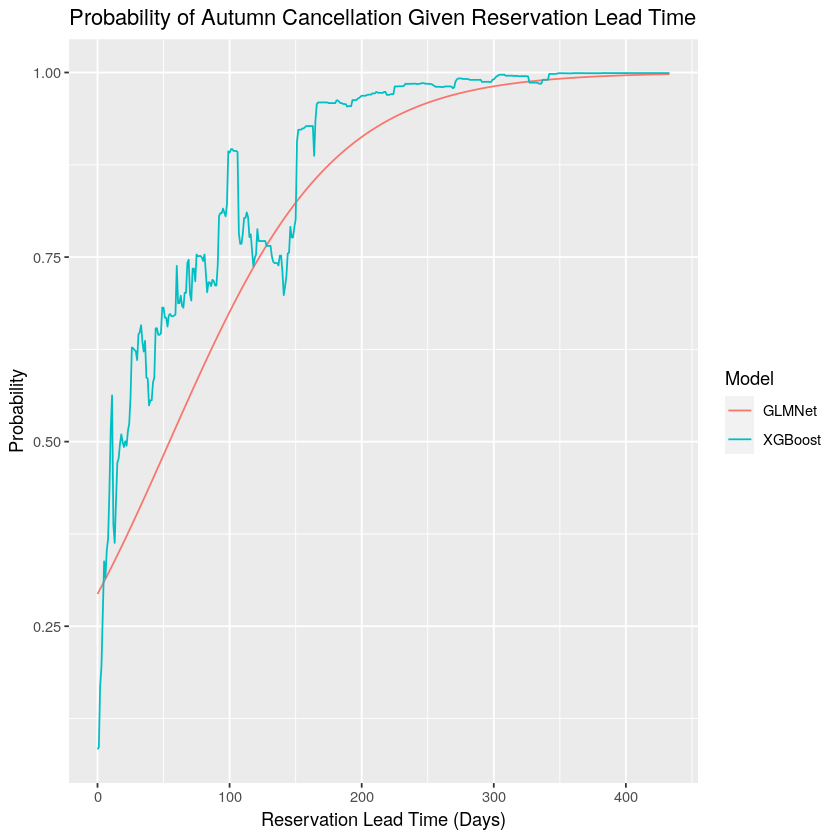

In [660]:
lead_time_preds %>%
    ggplot(aes(x=lead_time, y=probability, color=model)) +
        geom_line() +
        labs(title="Probability of Autumn Cancellation Given Reservation Lead Time",
            x="Reservation Lead Time (Days)", y="Probability",color="Model")

### Lead Time by Model and Season

In [661]:
# Create encoding for each season
seasons <- c("seasonwinter","seasonspring", "seasonsummer")
lead_time_season_grid <- lead_time_grid

for (s in seasons) {
    temp <- lead_time_grid
    temp[,s] <- rep(1,lead_time_len)
    lead_time_season_grid <- rbind(lead_time_season_grid, temp)
    rm(temp)
}

# Make predictions and format season column
season_lead_time_preds = lead_time_season_grid %>%
    as_tibble() %>%
    mutate(season = case_when(
        seasonwinter==1 ~ "Winter",
        seasonsummer==1 ~ "Summer",
        seasonspring==1 ~ "Spring",
        seasonwinter==0 & seasonsummer==0 & seasonspring==0 ~ "Autumn"
    )) %>%
    select(lead_time, season) %>%
    mutate(
        # XGBoost pred and format
        XGBoost = predict(boostOut, lead_time_season_grid,type="prob")%>%pull("Canceled"),
        # GLMNet pred and format
        GLMNet = as.vector(
            predict(glmnetOut, lead_time_season_grid,s=elasticOut$bestTune$lambda, type="response")[,"s1"]
        ),
        # Un-standardize lead time
        lead_time = lead_time*pre_process_function$std[["lead_time"]]+pre_process_function$mean[["lead_time"]]
    ) %>%
    pivot_longer(!c(lead_time,season), names_to="model", values_to="probability")
head(season_lead_time_preds)

lead_time,season,model,probability
<dbl>,<chr>,<chr>,<dbl>
0,Autumn,XGBoost,0.08332986
0,Autumn,GLMNet,0.29360043
1,Autumn,XGBoost,0.08596462
1,Autumn,GLMNet,0.29695507
2,Autumn,XGBoost,0.16863900
2,Autumn,GLMNet,0.30033175


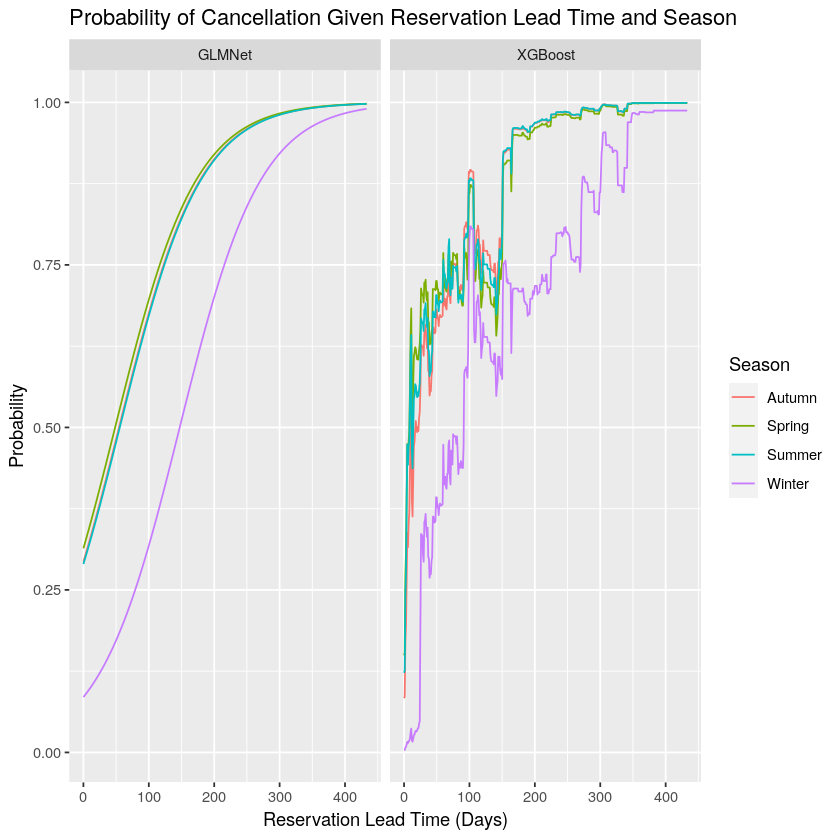

In [662]:
season_lead_time_preds %>%
    ggplot(aes(x=lead_time, y=probability, color=season)) +
        geom_line() +
        labs(title="Probability of Cancellation Given Reservation Lead Time and Season",
            x="Reservation Lead Time (Days)", y="Probability",color="Season") +
        facet_wrap(~model)

# XGBoost Test Performance

In [371]:
boostTestPreds <- predict(boostOut, Xtest_mat,type="raw")
mean(boostTestPreds == Ytest)

[1] 0.8808918

XGBoost has a test performance of 88%, which is higher than the average accuracy in cross validation.

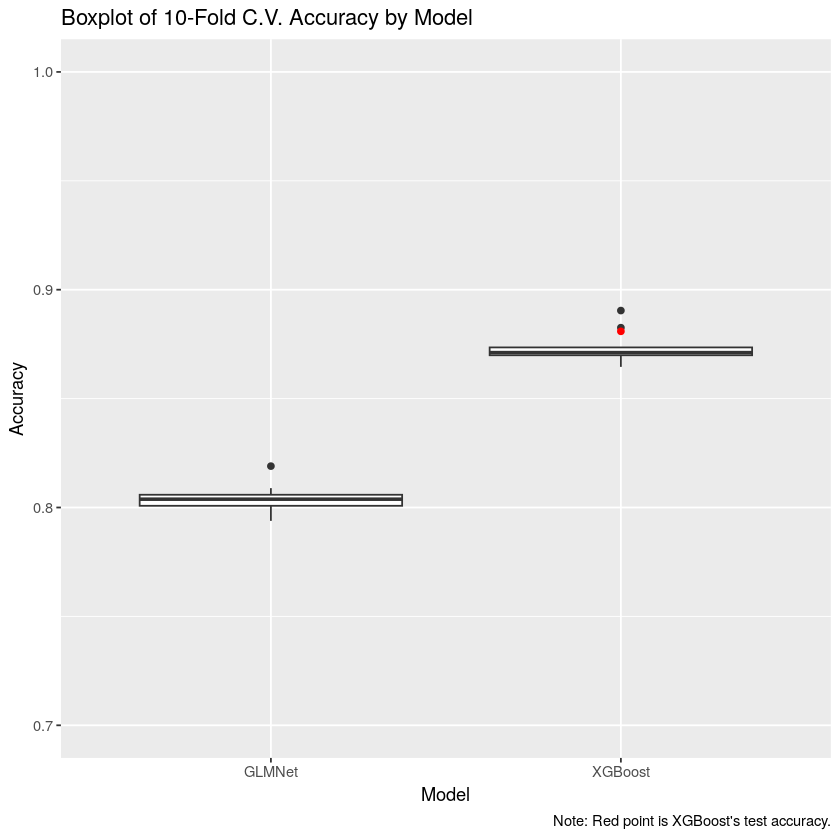

In [690]:
cv_accuracy <- tibble(GLMNet = elasticOut$resample$Accuracy,
                        XGBoost = boostOut$resample$Accuracy
                       ) %>%
    pivot_longer(c(GLMNet, XGBoost),names_to="Model", values_to="Accuracy")

test_acc <- tibble(Model="XGBoost", Accuracy=mean(boostTestPreds == Ytest))

ggplot() +
    geom_boxplot(data=cv_accuracy, aes(x=Model, y=Accuracy)) +
    geom_point(data=test_acc, aes(x=Model, y=Accuracy), color="red") +
    ylim(0.7,1) +
    labs(title="Boxplot of 10-Fold C.V. Accuracy by Model",
         caption="Note: Red point is XGBoost's test accuracy.")